In [59]:
# Dependencies

import pandas as pd
from pathlib import Path
import requests
from pprint import pprint
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import re

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")


In [49]:
# Store filepath in a variable
file_one = Path("Resources/us_counties_covid19_daily.csv")
file_two = Path("Resources/county_info.csv")

In [95]:
# Read our data file with the Pandas library
covid_df = pd.read_csv(file_one, encoding="ISO-8859-1")
county_df =pd.read_csv(file_two, encoding="ISO-8859-1")

In [65]:
# Show the first five rows.
covid_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [66]:
# Select rows in my date range
# Make a start date
start_date = '2020-09-01'

# Make an end date
end_date = '2020-11-30'

# Select DataFrame rows between two dates
mask = (covid_df['date'] > start_date) & (covid_df['date'] <= end_date)
fall_covid_df = covid_df.loc[mask]

fall_covid_df

,date,county,state,fips,cases,deaths
492429,2020-09-02,Autauga,Alabama,1001.0,1452,24.0
492430,2020-09-02,Baldwin,Alabama,1003.0,4583,42.0
492431,2020-09-02,Barbour,Alabama,1005.0,768,7.0
492432,2020-09-02,Bibb,Alabama,1007.0,562,8.0
492433,2020-09-02,Blount,Alabama,1009.0,1308,11.0
...,...,...,...,...,...,...
784205,2020-11-30,Sweetwater,Wyoming,56037.0,1888,6.0
784206,2020-11-30,Teton,Wyoming,56039.0,1644,2.0
784207,2020-11-30,Uinta,Wyoming,56041.0,1070,4.0
784208,2020-11-30,Washakie,Wyoming,56043.0,440,8.0


In [6]:
# Add the weather column and city to out DataFrame
#fall_covid_df['Temperature (C)'] = ''
#fall_covid_df['City'] = ''
#fall_covid_df

In [43]:
df = fall_covid_df.groupby(by=['date']).mean()
df

,fips,cases,deaths
date,,,
2020-09-02,31468.868873,1892.995671,58.820976
2020-09-03,31468.868873,1907.931333,59.181300
2020-09-04,31468.868873,1923.452690,59.473067
2020-09-05,31468.868873,1936.518244,59.698669
2020-09-06,31468.868873,1946.998453,59.866836
...,...,...,...
2020-11-26,31476.539633,3989.628580,83.097507
2020-11-27,31476.539633,4055.404006,83.595832
2020-11-28,31476.539633,4100.748922,83.945707


In [45]:
df = df.reset_index()

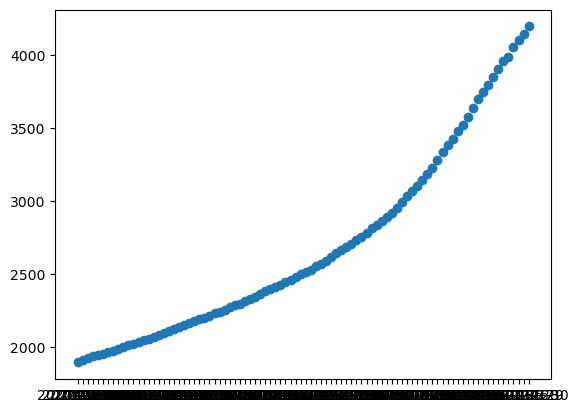

In [46]:
plt.scatter(df['date'], df['cases'])
plt.show()